# Local Group Halo Properties: Demo Inference

We approximate the local group distance, radial velocity and proper motion likelihood function by sampling from the posterior distributions for these variables reported in the literature and transforming to kinematic variables in the M31-centric coordinate system.

In [1]:
%matplotlib inline
import localgroup
import triangle
import sklearn
from sklearn import mixture
import numpy as np
import pickle
import matplotlib.patches as mpatches

Inside the Likelihood object is a "triplet" object called T, which contains an array of sample local groups, each with kinematic parameters consistent with the observational data. Let's plot these kinematic parameters in a "triangle" figure, to show all their 1 and 2-D marginal distributions.

In [2]:
L = localgroup.Likelihood(isPair=True)
L.generate(Nsamples=200000)

Inside method: heliocentric_equatorial_spherical_to_galactocentric_cartesian
l =  [ 121.17440269  121.17440269  121.17440269 ...,  121.17440269  121.17440269
  121.17440269]
b =  [-21.57299867 -21.57299867 -21.57299867 ..., -21.57299867 -21.57299867
 -21.57299867]
v_west:  125.142141 +/- 30.772739
v_north: -73.789607 +/- 28.388686
xh, yh, zh, vxh, vyh, vzh =  [-0.3822085  -0.40032231 -0.37580441 ..., -0.3590341  -0.37341088
 -0.38001615] [ 0.63173803  0.66167766  0.62115294 ...,  0.59343393  0.61719678
  0.62811437] [-0.29193518 -0.30577072 -0.28704366 ..., -0.27423431 -0.28521546
 -0.29026064] [ 81.2535378   92.48242827  77.8581032  ...,  24.2428279   51.86566755
  41.82824298] [-325.56231271 -294.83429411 -319.59252536 ..., -346.88797093 -306.37665435
 -338.74413911] [ 11.50865218  57.98827019  24.73113142 ...,  35.98798026  85.14697642
  30.10490468]


localgroup/halo.py:134: RuntimeWarning: invalid value encountered in divide
  self.v_r = (self.x*self.vx + self.y*self.vy + self.z*self.vz)/self.D


In [3]:
L.set_PDF(mixture.GMM(n_components=10, covariance_type='full'))
L.approximate()

Quantiles:
[(0.16, 0.73436590003364632), (0.5, 0.77415580967733555), (0.84, 0.81400125874697227)]
Quantiles:
[(0.16, -113.4431019876431), (0.5, -109.07963501050034), (0.84, -104.68101510093527)]
Quantiles:
[(0.16, 18.926644210999289), (0.5, 37.698360069840305), (0.84, 61.151366047856321)]


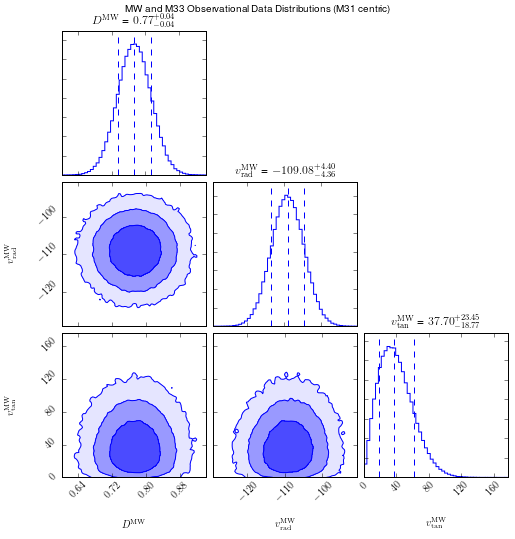

In [4]:
figure_obs = L.plot_samples(10, color='b', overlay=False)

The above plot shows a Gaussian Mixture model fitted Gaussians. The shaded regions show two standard deviations. The samples data has been preprocessed to zero the mean and scale by standard deviation. Since we are using the Gaussian Mixture Model to model the underlying PDF of the data, more components is always better. 

# How to evaluate goodness of fit:

Due to lack of a standard goodness of fit test for GMM's, the best we can do is graphically show that the model reproduces the data well. We proceed by drawing a set of points from the fitted model, where each point is a local group with (MW_D, MW_vr, MW_vt, M33_D, M33_vr, M33_vt). We then plot the 1D and 2D marginalizations of the drawn point set and show that the marginalizations match the marginalizations of the true data.

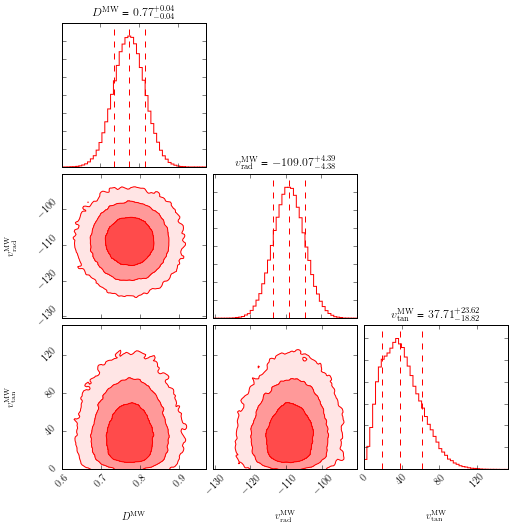

In [5]:
figure_model = L.model_gof(L.T.Nsamples, color="r", fig=None)

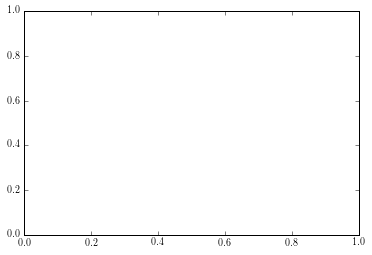

In [6]:
L.model_gof(L.T.Nsamples, color="r", fig=figure_obs)
red_patch = mpatches.Patch(color='red')
blue_patch = mpatches.Patch(color='blue')
figure_obs.legend(handles=[red_patch, blue_patch], labels=["Model Generated", "Observation Generated"])

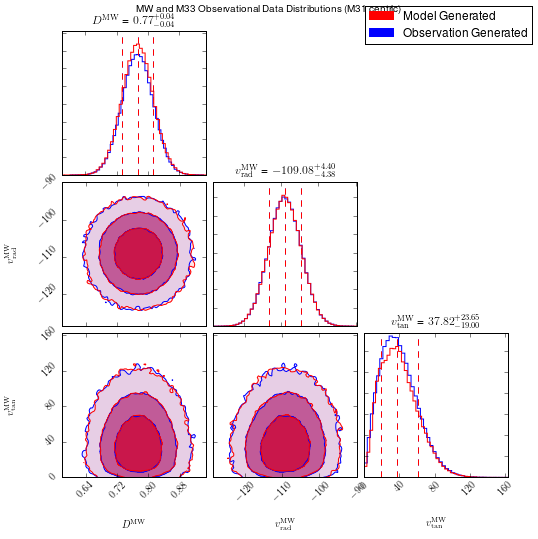

In [7]:
figure_obs

The above plot shows that the points drawn from the model create a population that is very similar to the true data.

In [8]:
#figure_obs.savefig("/afs/slac.stanford.edu/u/ki/mwillia1/Thesis/LocalGroupHaloProps/doc/thesis/plots/model_gof.png")

# Reading Simulation Points:

Below we read the preconfigured files containing the Consuelo (soon to be Dark Sky) Local Group analogs into a Triplet object. We plot the marginalizations of the simulation data, which allows us to compare with the LG prior.

In [9]:
path = '/afs/slac.stanford.edu/u/ki/mwillia1/Thesis/data_files/MW_M31_pairs.txt'
npoints = 900000
halo_props = ['MW_Mvir', 'M31_Mvir', 'M33_Mvir']

In [10]:
Tr = localgroup.Triplet(isPair=True)
Tr.read_sim_points(path, npoints, halo_props)

In [11]:
Tr.transform_to_M31(sim=True)

sim_sample length before:  (900000, 3)
sim_sample length after:  (898283, 3)


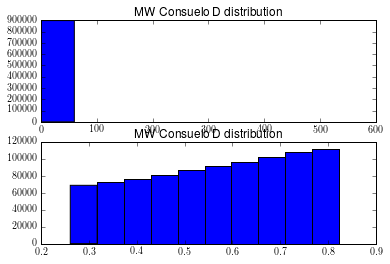

In [12]:
Tr.dist_filter((Tr.sim_samples[:,0] < 10))

In [13]:
Tr.preprocess(L.samples_means, L.samples_stds, mode='sim')

Quantiles:
[(0.16, 0.37470175499896119), (0.5, 0.58021724379755191), (0.84, 0.75013680085702061)]
Quantiles:
[(0.16, -129.9679936260894), (0.5, -49.716139020064915), (0.84, -9.6896436029769468)]
Quantiles:
[(0.16, 15.512624369745097), (0.5, 43.326786049757409), (0.84, 133.94621403732998)]
Quantiles:
[(0.16, 11.181129272128443), (0.5, 11.567111333623473), (0.84, 12.269594191714194)]
Quantiles:
[(0.16, 10.962839842665941), (0.5, 11.505640996272863), (0.84, 12.181129272128443)]


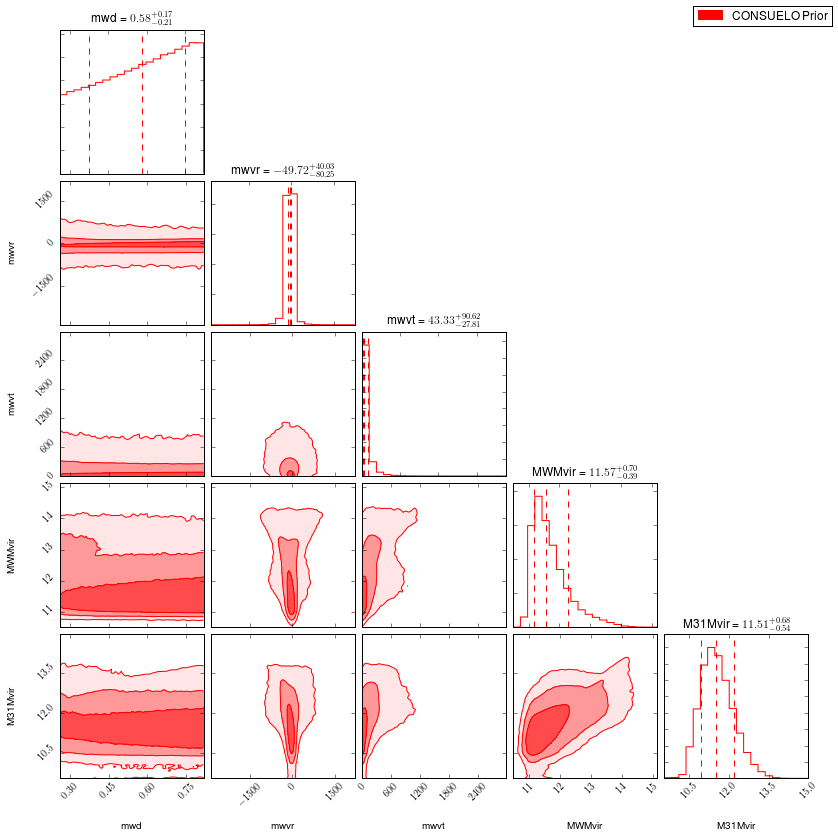

In [14]:
Tr.unprocess(L.samples_means, L.samples_stds, mode='sim')
data = np.transpose(np.vstack((np.transpose(Tr.sim_samples), np.log10(Tr.MW.Mvir), np.log10(Tr.M31.Mvir))))
labs=["mwd", "mwvr", "mwvt", "MWMvir", "M31Mvir"]
sim_plot = triangle.corner(data, labels=labs, quantiles=[0.16,0.5,0.84], fig=None, weights=None,\
                         plot_contours=True, show_titles=True, title_args={"fontsize": 12}, \
                         plot_datapoints=False, bins=20, color='r', label_kwargs={"fontsize": 16})
red_patch = mpatches.Patch(color='r')
sim_plot.legend(handles=[red_patch], labels=["CONSUELO Prior"])
Tr.preprocess(L.samples_means, L.samples_stds, mode='sim')

In [ ]:
#name = 'gmm_CONSUELO_prior.png'
#sim_plot.savefig('/afs/slac.stanford.edu/u/ki/mwillia1/Thesis/LocalGroupHaloProps/doc/thesis/plots/asurps/'+name)

In [ ]:
dat = np.transpose(np.vstack((np.transpose(Tr.sim_samples), np.log10(Tr.M31.Mvir), np.log10(Tr.MW.Mvir))))
Tr.GMM(40, dat)

In [ ]:
Tr.GMM_sample(12200000)

gmm_MW = np.copy(Tr.gmm_samples[:,4])
gmm_M31 = np.copy(Tr.gmm_samples[:,3])
gmm_LG = np.log10(np.power(10,gmm_MW) + np.power(10,gmm_M31))

Tr.gmm_samples = Tr.gmm_samples[:,0:3]

In [ ]:
Tr.compute_model_weights(L, 'gmm')

In [ ]:
Tr.calculate_N95()

In [ ]:
Tr.unprocess(L.samples_means, L.samples_stds, 'gmm')
data2 = np.transpose(np.vstack((np.transpose(Tr.gmm_samples), gmm_MW, gmm_M31)))
labs=["mwd", "mwvr", "mwvt", "MWMvir", "M31Mvir"]
pl = triangle.corner(data2, labels=labs, quantiles=[0.16,0.5,0.84], fig=None, weights=None,\
                         plot_contours=True, show_titles=True, title_args={"fontsize": 12}, \
                         plot_datapoints=False, bins=20, color='c')
Tr.preprocess(L.samples_means, L.samples_stds, mode='gmm')

In [ ]:
Tr.unprocess(L.samples_means, L.samples_stds, mode='sim')
data = np.transpose(np.vstack((np.transpose(Tr.sim_samples), np.log10(Tr.MW.Mvir), np.log10(Tr.M31.Mvir))))
labs=["mwd", "mwvr", "mwvt", "MWMvir", "M31Mvir"]
sim_plot = triangle.corner(data, labels=labs, quantiles=[0.16,0.5,0.84], fig=Npl, weights=None,\
                         plot_contours=True, show_titles=True, title_args={"fontsize": 12}, \
                         plot_datapoints=False, bins=20, color='r', label_kwargs={"fontsize": 16})
red_patch = mpatches.Patch(color='r')
cyan_patch = mpatches.Patch(color='c')
sim_plot.legend(handles=[red_patch, cyan_patch], labels=["CONSUELO Prior", "GMM-fit CONSUELO Prior"])
Tr.preprocess(L.samples_means, L.samples_stds, mode='sim')

In [ ]:
labs = ["MWMvir", "M31Mvir", "MW+M31"]
all_mvir = np.transpose(np.vstack((gmm_MW, gmm_M31, gmm_LG)))
figure = triangle.corner(all_mvir, labels=labs, quantiles=[0.16,0.5,0.84], fig=None, weights=Tr.weights,\
                         plot_contours=True, show_titles=True, title_kwargs={"fontsize": 12}, \
                         plot_datapoints=False, bins=20, color='red')